Compare output from dask streaming analysis to results from Fluctana.

We calculate results from RMCs examples/nersc/check_correlation.py for Channels L1102 and L0906 to
results from the streaming analysis package.


In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [59]:
# Run the fluctana code from RMCs examples/nersc/check_correlation.py

cfg =  None
self.fname =  /global/cscratch1/sd/rkube/KSTAR/kstar_streaming/018431/ECEI.018431.LFS.h5
Rading init: 
ECEI file = /global/cscratch1/sd/rkube/KSTAR/kstar_streaming/018431/ECEI.018431.LFS.h5
Adding data, norm =  0 , trange =  [1.0, 1.02]
Data is not normalized ECEI
get_data, time =  1.00000000000112 1.0199980000011402 , idx1 =  560000 , idx2 =  570000 , oidx1 =  500 , oidx2 =  5500
cfg =  None
self.fname =  /global/cscratch1/sd/rkube/KSTAR/kstar_streaming/018431/ECEI.018431.LFS.h5
Rading init: 
ECEI file = /global/cscratch1/sd/rkube/KSTAR/kstar_streaming/018431/ECEI.018431.LFS.h5
Adding data, norm =  0 , trange =  [1.0, 1.02]
Data is not normalized ECEI
get_data, time =  1.00000000000112 1.0199980000011402 , idx1 =  560000 , idx2 =  570000 , oidx1 =  500 , oidx2 =  5500
---- DATA SET # 0 for [1.000000, 1.020000] s ----
[000:ECEI_L1102]
---- DATA SET # 1 for [1.000000, 1.020000] s ----
[000:ECEI_L0906]
dnum 0 fftbins 37 with hann size 512 overlap 0.5 detrend 0 full 1
dnum 1 f

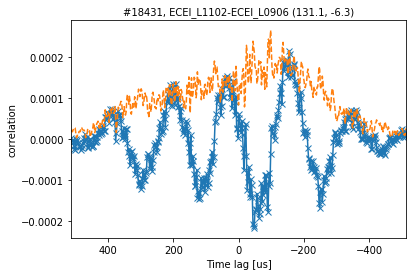

['Dlist', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_channel', 'add_data', 'bicoherence', 'chplane', 'coherence', 'corr_coef', 'correlation', 'cplot', 'cross_phase', 'cross_power', 'cwt', 'del_channel', 'del_data', 'downsample', 'fftbins', 'fftbins_bicoh_test', 'filt', 'hurst', 'intermittency', 'iplot', 'js_complexity', 'kurtosis', 'list_data', 'mplot', 'nonlin_evolution', 'ns_entropy', 'oplot', 'skewness', 'skplane', 'skw', 'spec', 'svd_filt', 'xspec']


In [74]:
def test_rmc():
    import sys
    sys.path.append("/global/homes/r/rkube/repos/fluctana_rmc")
    from fluctana import FluctAna, KstarEcei

    shot = 18431
    trange = [1.0, 1.02]
    clist = [['ECEI_L1102'], ['ECEI_L0906']]

    # call fluctana
    A = FluctAna()

    # add data
    A.add_data(KstarEcei(shot=shot, clist=clist[0], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=0)
    A.add_data(KstarEcei(shot=shot, clist=clist[1], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=0)

    # list data
    A.list_data()

    # do fft; full = 1 
    A.fftbins(nfft=512,window='hann',overlap=0.5,detrend=0,full=1)

    # calculate correlation using data sets done and dtwo. results are saved in A.Dlist[dtwo].val
    A.correlation(done=0, dtwo=1)

    # plot the results; dnum = data set number, cnl = channel number list to plot
    A.mplot(dnum=1,cnl=range(len(A.Dlist[1].clist)),type='val')

    print(dir(A))
    
    return(A)
res = test_rmc()
    

In [69]:
res.Dlist[0].data[0].shape

(10000,)

In [46]:
res.list_data()

---- DATA SET # 0 for [0.000000, 0.020000] s ----
[000:ECEI_L1102]
---- DATA SET # 1 for [0.000000, 0.020000] s ----
[000:ECEI_L0906]


In [48]:
with np.load("../ralphs_task_000.npz") as df:
    res_dask = df["res"]
    
with np.load("../stream_data_s000.npz") as df:
    stream_data = df["stream_data"]

In [50]:
stream_data.shape

(192, 10000)